<a href="https://colab.research.google.com/github/helloitsdaksh/Tensorflow_colab/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

We've seen the power of tranfer learning feature extraction and fine-tuning, now its time to scale up to all of the classes of Food101(101 total classes of food)

Our goal is to **beat the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)'s results with 10% of data**


## What we're going to cover

We're going to go through the follow with TensorFlow:

- Downloading and preparing 10% of the Food101 data (10% of training data)
- Training a feature extraction transfer learning model on 10% of the Food101 training data
- Fine-tuning our feature extraction model
- Saving and loaded our trained model
- Evaluating the performance of our Food Vision model trained on 10% of the training data
  - Finding our model's most wrong predictions
- Making predictions with our Food Vision model on custom images of food

## How you can use this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

## Creating helper functions:

In [2]:
!wget https://raw.githubusercontent.com/helloitsdaksh/Tensorflow_colab/main/Extras/helper_functions.py

--2021-09-18 20:22:53--  https://raw.githubusercontent.com/helloitsdaksh/Tensorflow_colab/main/Extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11617 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  11.34K  --.-KB/s    in 0s      

2021-09-18 20:22:53 (70.7 MB/s) - ‘helper_functions.py’ saved [11617/11617]



In [3]:
# import series of helper functions for our notebook
from helper_functions import *

In [1]:
!nvidia-smi

Sat Sep 18 20:22:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 101 Food Classes: Working with less data

So far we've confirmed the transfer learning model's we've been using work pretty well with the 10 Food Classes dataset. Now it's time to step it up and see how they go with the full 101 Food Classes.

In the original [Food101](https://www.kaggle.com/dansbecker/food-101) dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

In [4]:
## Downloading and Preprocessing the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 
unzip_data("101_food_classes_10_percent.zip")

# Creating the directories
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2021-09-18 20:25:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.192.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   127MB/s    in 13s     

2021-09-18 20:25:56 (121 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/miso_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheese_plate'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bruschetta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_carpaccio'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/mussels'.
There are 0 directories and 75 images in

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE,
                                                                                batch_size = 32) #default
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Wonderful! It looks like our data has been imported as expected with 75 images per class in the training set (75 images * 101 classes = 7575 images) and 25250 images in the test set (250 images * 101 classes = 25250 images). 


## Train a big dog model with transfer learning on 10% of 101 food classes

Our food image data has been imported into TensorFlow, time to model it.

To keep our experiments swift, we're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

More specifically, our goal will be to see if we can beat the baseline from original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) (50.76% accuracy on 101 classes) with 10% of the training data and the following modelling setup:
* A [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
* Data augmentation built right into the model
* A headless (no top layers) [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) architecture from `tf.keras.applications` as our base model
* A `Dense` layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
* Categorical crossentropy as the loss function since we're dealing with more than two classes
* The Adam optimizer with the default settings
* Fitting for 5 full passes on the training data while evaluating on 15% of the test data

It seems like a lot but these are all things we've covered before in the [Transfer Learning in TensorFlow Part 2: Fine-tuning notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb).

Let's start by creating the `ModelCheckpoint` callback. 

Since we want our model to perform well on unseen data we'll set it to monitor the validation accuracy metric and save the model weights which score the best on that.

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)

In [10]:
# Create data augmentation layer to incoporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
    preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
    preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
    preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
    preprocessing.RandomZoom(0.2), # randomly zoom into an image
    # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

Beautiful! We'll be able to insert the `data_augmentation` Sequential model as a layer in our Functional API model. That way if we want to continue training our model at a later time, the data augmentation is already built right in.

Speaking of Functional API model's, time to put together a feature extraction transfer learning model using [`tf.keras.applications.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) as our base model.

We'll import the base model using the parameter `include_top=False` so we can add on our own output layers, notably `GlobalAveragePooling2D()` (condense the outputs of the base model into a shape usable by the output layer) followed by a `Dense` layer.

In [11]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False,)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape = (224,224,3), name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer") (x)
outputs = layers.Dense(101, activation="softmax", name = "output_layer") (x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [12]:
# Get a summary of model we created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [15]:
# compile
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15*len(test_data)),
                                           callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 100s 391ms/step - loss: 2.3540 - accuracy: 0.4528 - val_loss: 2.2541 - val_accuracy: 0.4476
Epoch 2/5
237/237 [==============================] - 84s 350ms/step - loss: 1.9555 - accuracy: 0.5341 - val_loss: 2.0560 - val_accuracy: 0.4831
Epoch 3/5
237/237 [==============================] - 79s 329ms/step - loss: 1.7449 - accuracy: 0.5770 - val_loss: 1.9762 - val_accuracy: 0.4963
Epoch 4/5
237/237 [==============================] - 75s 314ms/step - loss: 1.5841 - accuracy: 0.6117 - val_loss: 1.9513 - val_accuracy: 0.4974
Epoch 5/5
237/237 [==============================] - 73s 305ms/step - loss: 1.4719 - accuracy: 0.6384 - val_loss: 1.9142 - val_accuracy: 0.5037


In [17]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 101s 127ms/step - loss: 1.6840 - accuracy: 0.5527


[1.683962106704712, 0.5526732802391052]

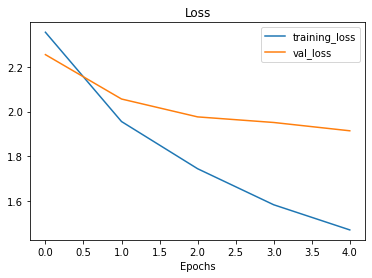

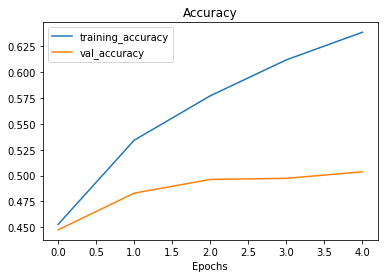

In [18]:
plot_loss_curves(history_all_classes_10_percent)